In [1]:
from image_loader import ImageLoader, ImagePreprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import cv2
import matplotlib.pyplot as plt
from train_svm_model import deskew, load_images, learn, predict
from joblib import dump, load
from sklearn.model_selection import GridSearchCV

In [2]:
img_size = (100, 100)
train_dir = "images/train/train"
test_dir = "images/test/test"
classes = {"cat": 0, "dog": 1}
SZ = img_size[0]

In [3]:
model = SVC(C=8.5, gamma=0.5)
clf = make_pipeline(StandardScaler(), PCA(n_components=2000), model)

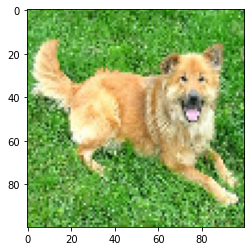

In [3]:
image_loader = ImageLoader(dir_name=test_dir)
test_img = image_loader.get_one_image(new_size=img_size, path="4.jpg")
test_img = cv2.cvtColor(test_img["data"], cv2.COLOR_BGR2RGB)
plt.imshow(test_img)

In [5]:
# learn(1, 25000, clf, train_dir, img_size=img_size, classes=classes)

epoch: 0 	 Accuracy: 77.44


In [7]:
# dump(clf, "svm_classifier.joblib")

['svm_classifier.joblib']

In [8]:
# clf2 = load("svm_classifier.joblib")

In [4]:
train_loader = ImageLoader(dir_name=train_dir)

In [5]:
train_hog = []
train_labels = []

In [7]:
train_images = []
for _ in range(50):
    img = train_loader.get_one_image(labels=classes, new_size=img_size)
    train_images.append(img["data"])
    train_labels.append(img["target"])

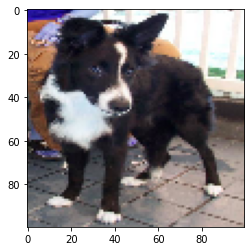

In [8]:
plt.imshow(train_images[0])

In [20]:
gray_scaled_train = []
for im in train_images:
    gray_scaled_train.append(np.uint8(train_loader.rgb2gray(im)))

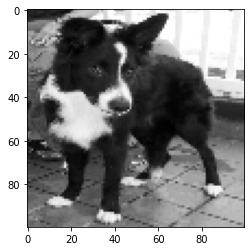

In [21]:
plt.imshow(gray_scaled_train[0], cmap="gray")

In [22]:
train_labels

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0]

In [18]:
preproc = ImagePreprocessing(img_size=img_size)

In [23]:
for im in gray_scaled_train:
    train_hog.append(preproc.get_hog(im))

In [30]:
model = SVC()

In [32]:
# сбалансирован ли набор
unique, count = np.unique(train_labels, return_counts=True)
dict(zip(unique, count))

{0: 28, 1: 22}

In [35]:
parameters = {"C": np.linspace(1, 10, 20),
             "gamma": np.linspace(0.1, 1, 20),
             "kernel": ["rbf", "poly", "linear", "sigmoid"]}

In [36]:
clf = GridSearchCV(model, param_grid=parameters, n_jobs=2)
clf.fit(train_hog, train_labels)

GridSearchCV(estimator=SVC(), n_jobs=2,
             param_grid={'C': array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ]),
                         'gamma': array([0.1       , 0.14736842, 0.19473684, 0.24210526, 0.28947368,
       0.33684211, 0.38421053, 0.43157895, 0.47894737, 0.52631579,
       0.57368421, 0.62105263, 0.66842105, 0.71578947, 0.76315789,
       0.81052632, 0.85789474, 0.90526316, 0.95263158, 1.        ]),
                         'kernel': ['rbf', 'poly', 'linear', 'sigmoid']})

In [37]:
clf.best_params_

{'C': 1.4736842105263157, 'gamma': 0.1, 'kernel': 'rbf'}

In [38]:
# пройдёмся ещё по меньшим значениям гаммы и C
good_model = SVC(C=1.4736842105263157, kernel="rbf")
clf_gamma = GridSearchCV(good_model, param_grid={"gamma": np.linspace(0, 0.1, 20), "C": np.linspace(1, 1.5, 20)})

In [39]:
clf_gamma.fit(train_hog, train_labels)

GridSearchCV(estimator=SVC(C=1.4736842105263157),
             param_grid={'C': array([1.        , 1.02631579, 1.05263158, 1.07894737, 1.10526316,
       1.13157895, 1.15789474, 1.18421053, 1.21052632, 1.23684211,
       1.26315789, 1.28947368, 1.31578947, 1.34210526, 1.36842105,
       1.39473684, 1.42105263, 1.44736842, 1.47368421, 1.5       ]),
                         'gamma': array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
       0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
       0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
       0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ])})

In [41]:
clf_gamma.best_params_

{'C': 1.2105263157894737, 'gamma': 0.05789473684210526}

In [42]:
good_model = SVC(C=1.2105263157894737, gamma=0.05789473684210526, kernel="rbf")

In [44]:
good_model.fit(train_hog, train_labels)

SVC(C=1.2105263157894737, gamma=0.05789473684210526)

In [45]:
print(f'accuracy: {accuracy_score(good_model.predict(train_hog), train_labels)*100}')

accuracy: 100.0


In [3]:
model = SVC(C=1.2105263157894737, gamma=0.05789473684210526, kernel="rbf")

In [4]:
learn(n_epochs=1, n_samples=25000, clf=model, train_dir=train_dir, img_size=img_size, classes=classes)
dump(model, "clf1.joblib")

epoch: 0 	 Accuracy: 90.08


['clf1.joblib']

In [5]:
test_loader = ImageLoader(dir_name=test_dir)

In [10]:
predict(img_name="5.jpg", model=model, dir_name=test_dir, new_size=img_size)

array([0])